<a href="https://colab.research.google.com/github/kmjohnson3/Intro-to-MRI/blob/master/MachineLearning/VarNetToyExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This code is meant as a toy/teaching example roughly following the paper:

Hammernik K, Klatzer T, Kobler E, Recht MP, Sodickson DK, Pock T, Knoll F. Learning a variational network for reconstruction of accelerated MRI data. Magnetic Resonance in Medicine. 2018;79(6):3055–3071. [link](https://onlinelibrary.wiley.com/doi/epdf/10.1002/mrm.26977)

Major differences include:
*   Uses synthetic data using random shapes and fake 4 channel senstivity maps
*   Written in PyTorch (>1.8) with native complex support
*   The networks are slighty smaller and modified to train in ~10 minutes rather than days


In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.fft
import numpy as np
import skimage
import skimage.draw

Below are the MRI encoding operators. In MRI, the encoding operator if just a Fourier transform of the image multiplied by a senssitivity map. The sensitivity map is essentially a smooth complex function that details how each RF reciever (~antenna) detects the signal. We can detail this in matrix form as:

$Ex = FMx = d + \epsilon$

where:
*   $E$ is the encoding operator ($N_m$ x $N_xN_y$)
*   $F$ is the Fourier transform operator ($N_m$ x $N_xN_yN_c$) 
*   $M$ is a sensitivity matrix, a stack of diagonal matrices ($N_xN_yN_c$ x $N_xN_y$)
*   $N_m$ is the number of measurements
*   $N_x$ is the image size in $x$
*   $N_y$ is the image size in $y$
*   $N_c$ is the number of coils ( 4 in this case)

We won't store these matrices but use operators to perform them. 

In [2]:
def sense_adjoint( maps, data):
    im = torch.fft.ifftshift( data, dim=(-2, -1))
    im = torch.fft.ifft2( im, dim=(-2,-1))
    im = torch.fft.fftshift( im, dim=(-2,-1))
    im *= torch.conj(maps)
    im = torch.sum(im, dim=-3, keepdim=True)
    return im

def sense( maps, image ):
    kdata = maps * image
    kdata = torch.fft.ifftshift(kdata, dim=(-2, -1))
    kdata = torch.fft.fft2( kdata, dim=(-2,-1))
    kdata = torch.fft.fftshift(kdata, dim=(-2, -1))
    return kdata

# Image generation
We will use fake data. Specifically, a 2D image with a number of circles generated at random. We are using the scikit-image function random_shapes [here](https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.random_shapes). However, in the scikit code the random generator is reinitialized every call. Below is just a copy of this with the randomness removed. It still relies on the core libraries in scikit.

In [3]:
def random_shapes(image_shape,
                  max_shapes,
                  min_shapes=1,
                  min_size=2,
                  max_size=None,
                  multichannel=False,
                  num_channels=1,
                  shape=None,
                  intensity_range=None,
                  allow_overlap=False,
                  num_trials=100,
                  random_seed=None,
                  *,
                  channel_axis=-1):
    """Generate an image with random shapes, labeled with bounding boxes.
    The image is populated with random shapes with random sizes, random
    locations, and random colors, with or without overlap.
    Shapes have random (row, col) starting coordinates and random sizes bounded
    by `min_size` and `max_size`. It can occur that a randomly generated shape
    will not fit the image at all. In that case, the algorithm will try again
    with new starting coordinates a certain number of times. However, it also
    means that some shapes may be skipped altogether. In that case, this
    function will generate fewer shapes than requested.
    Parameters
    ----------
    image_shape : tuple
        The number of rows and columns of the image to generate.
    max_shapes : int
        The maximum number of shapes to (attempt to) fit into the shape.
    min_shapes : int, optional
        The minimum number of shapes to (attempt to) fit into the shape.
    min_size : int, optional
        The minimum dimension of each shape to fit into the image.
    max_size : int, optional
        The maximum dimension of each shape to fit into the image.
    multichannel : bool, optional
        If True, the generated image has ``num_channels`` color channels,
        otherwise generates grayscale image. This argument is deprecated:
        specify `channel_axis` instead.
    num_channels : int, optional
        Number of channels in the generated image. If 1, generate monochrome
        images, else color images with multiple channels. Ignored if
        ``multichannel`` is set to False.
    shape : {rectangle, circle, triangle, ellipse, None} str, optional
        The name of the shape to generate or `None` to pick random ones.
    intensity_range : {tuple of tuples of uint8, tuple of uint8}, optional
        The range of values to sample pixel values from. For grayscale
        images the format is (min, max). For multichannel - ((min, max),)
        if the ranges are equal across the channels, and
        ((min_0, max_0), ... (min_N, max_N)) if they differ. As the
        function supports generation of uint8 arrays only, the maximum
        range is (0, 255). If None, set to (0, 254) for each channel
        reserving color of intensity = 255 for background.
    allow_overlap : bool, optional
        If `True`, allow shapes to overlap.
    num_trials : int, optional
        How often to attempt to fit a shape into the image before skipping it.
    random_seed : int, optional
        Seed to initialize the random number generator.
        If `None`, a random seed from the operating system is used.
    channel_axis : int or None, optional
        If None, the image is assumed to be a grayscale (single channel) image.
        Otherwise, this parameter indicates which axis of the array corresponds
        to channels.
        .. versionadded:: 0.19
           ``channel_axis`` was added in 0.19.
    Returns
    -------
    image : uint8 array
        An image with the fitted shapes.
    labels : list
        A list of labels, one per shape in the image. Each label is a
        (category, ((r0, r1), (c0, c1))) tuple specifying the category and
        bounding box coordinates of the shape.
    Examples
    --------
    >>> import skimage.draw
    >>> image, labels = skimage.draw.random_shapes((32, 32), max_shapes=3)
    >>> image # doctest: +SKIP
    array([
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
    >>> labels # doctest: +SKIP
    [('circle', ((22, 18), (25, 21))),
     ('triangle', ((5, 6), (13, 13)))]
    """
    if min_size > image_shape[0] or min_size > image_shape[1]:
        raise ValueError('Minimum dimension must be less than ncols and nrows')
    max_size = max_size or max(image_shape[0], image_shape[1])

    if channel_axis is None:
        num_channels = 1

    if intensity_range is None:
        intensity_range = (0, 254) if num_channels == 1 else ((0, 254), )
    else:
        tmp = (intensity_range, ) if num_channels == 1 else intensity_range
        for intensity_pair in tmp:
            for intensity in intensity_pair:
                if not (0 <= intensity <= 255):
                    msg = 'Intensity range must lie within (0, 255) interval'
                    raise ValueError(msg)

    #random = np.random.RandomState(random_seed)
    user_shape = shape
    image_shape = (image_shape[0], image_shape[1], num_channels)
    image = np.full(image_shape, 255, dtype=np.uint8)
    filled = np.zeros(image_shape, dtype=bool)
    labels = []

    num_shapes = np.random.randint(min_shapes, max_shapes + 1)
    colors = skimage.draw._random_shapes._generate_random_colors(num_shapes, num_channels,
                                     intensity_range, np.random)
    shape = (min_size, max_size)
    for shape_idx in range(num_shapes):
        if user_shape is None:
            shape_generator = np.random.choice(skimage.draw._random_shapes.SHAPE_CHOICES)
        else:
            shape_generator = skimage.draw._random_shapes.SHAPE_GENERATORS[user_shape]
        for _ in range(num_trials):
            # Pick start coordinates.
            column = np.random.randint(max(1, image_shape[1] - min_size))
            row = np.random.randint(max(1, image_shape[0] - min_size))
            point = (row, column)
            try:
                indices, label = shape_generator(point, image_shape, shape,np.random)
            except ArithmeticError:
                # Couldn't fit the shape, skip it.
                indices = []
                continue
            # Check if there is an overlap where the mask is nonzero.
            if allow_overlap or not filled[indices].any():
                image[indices] = colors[shape_idx]
                filled[indices] = True
                labels.append(label)
                break
        else:
            warn('Could not fit any shapes to image, '
                 'consider reducing the minimum dimension')

    if channel_axis is None:
        image = np.squeeze(image, axis=2)
    else:
        image = np.moveaxis(image, -1, channel_axis)

    image=np.squeeze(image)
    return image, labels

# Data generator
From the images, we will generate data using simple simulated sensitivity maps. This is a very simple data generator. You can change the image size and examples per epoch, which are just made up.

In [4]:
class ToyDataGenerator(torch.utils.data.Dataset):
    def __init__(self, image_size=(64,64), examples_per_epoch=1000, channels=4):
        self.image_size = image_size
        self.examples_per_epoch = examples_per_epoch
        self.get_maps(channels)

    def get_maps(self, channels):
        if channels == 1:
            self.maps = torch.ones( (1,) + self.image_size, dtype=torch.complex64 )
        else:
            [x,y] = torch.meshgrid(torch.linspace(0,1,self.image_size[0]),torch.linspace(0,1,self.image_size[0]))
            self.maps = torch.stack( (x, y, 1.0-x,1-.0-y),dim=0).type(torch.complex64)

        self.maps /= torch.sqrt(torch.sum(torch.abs(self.maps)**2,dim=0,keepdim=True))

    def __len__(self):
        return self.examples_per_epoch

    def __getitem__(self, idx):

        # Images of random shapes
        image, labels = random_shapes(image_shape=self.image_size,
                                       max_shapes=10,
                                       min_shapes=1,
                                       min_size=2,
                                       max_size=None,
                                       multichannel=False,
                                       allow_overlap=True,
                                       shape='circle')
        
        # Convert background to 0 rather than 255
        image = 255 - image

        # Convert to tensor and scale 0 to 1
        image = torch.tensor(image).unsqueeze(0).unsqueeze(0)
        image = image / torch.max(torch.abs(image))

        # Add linear phase of random amount and direction
        import math
        a = 2.0 * math.pi * torch.rand(1)
        theta = torch.tensor([math.cos(a), -math.sin(a), 0.0, math.sin(a), math.cos(a), 0.0]).view(-1, 2, 3)
        phase = torch.nn.functional.affine_grid(theta, image.size())
        image = image[0]*torch.exp(1j*phase[...,0])

        # Generate data using the encoding operator
        data = sense( self.maps, image)

        # Add noise
        data = data + 1e-4*(torch.randn(data.shape)  + 1j*torch.randn(data.shape) )

        return self.maps, data, image


# Neural Network Components

These are some of the components to run this. We need:
*   Complex convolutions with kernel normalization
*   Radial basis function activation
*   The denoising CNN (VarNet)
*   The unrolled network


In [8]:
class RunningAverage:
    def __init__(self):  # initialization
        self.count = 0
        self.sum = 0

    def reset(self):
        self.count = 0
        self.sum = 0

    def update(self, value, n=1):
        self.count += n
        self.sum += value * n

    def avg(self):
        return self.sum / self.count


class RadialBasisActivation(nn.Module):
    def __init__(self, in_channels=1, channels=48):
        super(RadialBasisActivation, self).__init__()

        # Scaling and bias for each channel
        self.scale_in = nn.Conv2d(in_channels=in_channels, out_channels=channels, kernel_size=1)
        self.scale_out = nn.Conv2d(in_channels=channels, out_channels=in_channels, kernel_size=1, bias=False)
    
    def forward(self, input):

        # Apply a gaussian activation to real and imaginary
        activated_real = torch.exp(-self.scale_in(input.real)**2) 
        activated_imag = torch.exp(-self.scale_in(input.imag)**2)

        # Sum the channels using learned scaling
        out = self.scale_out(activated_real) + 1j*self.scale_out(activated_imag)

        return out

class ComplexReLu(nn.Module):
    def forward(self, input):
        mag = torch.abs( input)
        return torch.nn.functional.relu(mag).type(torch.complex64)/(mag+1e-6)*input

def apply_complex(fr, fi, input, dtype = torch.complex64):
    return (fr(input.real)-fi(input.imag)).type(dtype) + 1j*(fr(input.imag)+fi(input.real)).type(dtype)

class ComplexConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0,
                 dilation=1, groups=1, bias=True):
        super(ComplexConv2d, self).__init__()
        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)

    def forward(self, input):
        return apply_complex(self.conv_r, self.conv_i, input)

class NormalizedComplexConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0,
                 dilation=1, groups=1, bias=True):
        super(NormalizedComplexConv2d, self).__init__()

        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.norm = nn.LayerNorm((kernel_size, kernel_size), elementwise_affine=False)
        self.kernel_size = kernel_size
    def forward(self, input):

        weight_r = self.conv_r.weight - torch.mean(self.conv_r.weight)
        weight_i = self.conv_i.weight - torch.mean(self.conv_i.weight)
        weight_r = weight_r / torch.sum(weight_r ** 2)
        weight_i = weight_i / torch.sum(weight_i ** 2)

        real = torch.nn.functional.conv2d(input.real, weight_r, self.conv_r.bias, self.conv_r.stride, self.conv_r.padding, self.conv_r.dilation, self.conv_r.groups)\
               - torch.nn.functional.conv2d(input.imag, weight_i, self.conv_i.bias, self.conv_i.stride, self.conv_i.padding, self.conv_i.dilation, self.conv_i.groups)
        imag = torch.nn.functional.conv2d(input.imag, weight_r, self.conv_r.bias, self.conv_r.stride, self.conv_r.padding, self.conv_r.dilation, self.conv_r.groups)\
               + torch.nn.functional.conv2d(input.real, weight_i, self.conv_i.bias, self.conv_i.stride, self.conv_i.padding, self.conv_i.dilation, self.conv_i.groups)

        return real + 1j*imag

class ComplexConvTranspose2d(nn.Module):

    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0,
                 output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros'):

        super(ComplexConvTranspose2d, self).__init__()

        self.conv_r = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding,
                                       output_padding, groups, bias, dilation, padding_mode)
        self.conv_i = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding,
                                       output_padding, groups, bias, dilation, padding_mode)
    def forward(self, input):
        return apply_complex(self.conv_r, self.conv_i, input)

class NormalizedComplexConvTranspose2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros'):
        super(NormalizedComplexConvTranspose2d, self).__init__()

        self.conv_r = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, groups, bias, dilation, padding_mode)
        self.conv_i = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, groups, bias, dilation, padding_mode)
        self.norm = nn.LayerNorm((kernel_size, kernel_size), elementwise_affine=False)
    def forward(self, input):

        weight_r = self.conv_r.weight - torch.mean(self.conv_r.weight)
        weight_i = self.conv_i.weight - torch.mean(self.conv_i.weight)
        weight_r = weight_r / torch.sum(weight_r ** 2)
        weight_i = weight_i / torch.sum(weight_i ** 2)

        real = torch.nn.functional.conv_transpose2d(input.real, weight_r, self.conv_r.bias, self.conv_r.stride, self.conv_r.padding, self.conv_r.output_padding, self.conv_r.groups, self.conv_r.dilation)\
               - torch.nn.functional.conv_transpose2d(input.imag, weight_i, self.conv_i.bias, self.conv_i.stride, self.conv_i.padding, self.conv_i.output_padding, self.conv_i.groups, self.conv_i.dilation)
        imag = torch.nn.functional.conv_transpose2d(input.imag, weight_r, self.conv_r.bias, self.conv_r.stride, self.conv_r.padding, self.conv_r.output_padding, self.conv_r.groups, self.conv_r.dilation)\
               + torch.nn.functional.conv_transpose2d(input.real, weight_i, self.conv_i.bias, self.conv_i.stride, self.conv_i.padding, self.conv_i.output_padding, self.conv_i.groups, self.conv_i.dilation)

        return real + 1j*imag

class VarNet( nn.Module):
    def __init__(self, channels=9, kernel_size=5):
        super(VarNet, self).__init__()

        self.encoding_layers = nn.ModuleList()
        self.decoding_layers = nn.ModuleList()
        self.activation_layers = nn.ModuleList()
        self.channels = channels
        for f in range(channels):
            self.encoding_layers.append(NormalizedComplexConv2d(1,1,kernel_size=kernel_size, padding=kernel_size//2, bias=False))
            self.decoding_layers.append(NormalizedComplexConvTranspose2d(1,1,kernel_size=kernel_size, padding=kernel_size//2, bias=False))
            self.activation_layers.append(RadialBasisActivation(in_channels=1, channels=24))
            #self.activation_layers.append(ComplexReLu())

    def forward(self, image):

        image_temp = torch.zeros_like(image)
        for alayer, elayer, dlayer in zip(self.activation_layers, self.encoding_layers, self.decoding_layers):
            # Encode image
            encoded = elayer(image)

            #Activation
            encoded = alayer(encoded)

            # Decode the layer
            decoded = dlayer(encoded)

            # Add with scale to image
            image_temp += decoded / self.channels


        return image_temp


class UnrolledNetwork(nn.Module):
    def __init__(self, scale_init=1.0, inner_iter=10, denoiser='VarNet',*args, **kwargs):
        super(UnrolledNetwork, self).__init__()

        self.inner_iter = inner_iter
        self.scale_layers = nn.Parameter(scale_init * torch.ones([inner_iter]), requires_grad=True)

        if denoiser is 'VarNet':
            self.varnets = nn.ModuleList()
            for i in range(self.inner_iter):
                self.varnets.append(VarNet())
            self.denoiser = None
        else:
            self.denoiser = denoiser


    def forward(self, maps, kspace, mask):

        # Initialize
        image = sense_adjoint(maps, kspace * mask)

        # Loop iterations
        for i in range(self.inner_iter):
            image_old = image

            # Ex
            Ex = sense(maps, image_old)

            # Ex - d
            Ex -= kspace*mask

            # image = image - scale*E.H*(Ex-d)
            image = image_old - self.scale_layers[i] * sense_adjoint(maps, Ex)

            if self.denoiser is None:
                image = image + self.varnets[i](image_old)
            else:
                image = self.denoiser(image)


        return image


# Training 
This will train the network using a made up mask.

24 Train = 0.006616802024655044 Val = 0.008283681236207485


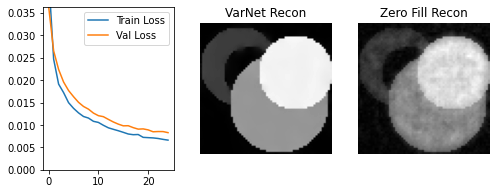

In [15]:

BATCH_SIZE = 10

# Set seed so that code runs everytime
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

'''
We will generate fake data for this, the data is circles, triangles, and squares
'''

# Validation loader called first due to random nature
data_val = ToyDataGenerator()
loader_val = DataLoader(dataset=data_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# precalc validation data to avoid randomness
vload = iter(loader_val)
vmaps, vdata,  image_truth = next(vload)

# Train loader
data_train = ToyDataGenerator()
loader_train = DataLoader(dataset=data_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

'''
Add a sampling mask. This will remove a number of points to simulate undersampling
'''
mask = torch.rand((1, 1, vmaps.shape[-2], vmaps.shape[-1]))
sampling_faction = 0.5
mask[mask <= sampling_faction] = 0.0
mask[mask > sampling_faction] = 1.0
mask = 1.0 - mask
mask[:,:,(mask.shape[2]//2-5):(mask.shape[2]//2+5),(mask.shape[3]//2-5):(mask.shape[3]//2+5)] = 1.0

'''
Use mean square error loss. We need a custom function since this is complex
'''
def loss_fcn( truth, input):
    loss = torch.mean( torch.abs(truth - input))
    return loss


'''
Define the network. You can also pass a nn.Module as a denoiser
'''
#model = UnrolledNetwork( inner_iter=10, denoiser=nn.Identity()) 
model = UnrolledNetwork( inner_iter=10)
model.cuda()

'''
Define an optimizer. 
'''
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_avg = []
val_loss_avg = []

for epoch in range(25):
    train_avg = RunningAverage()
    val_avg = RunningAverage()

    model.train()
    for idx, (maps, data, image_true) in enumerate(loader_train):

        # Zero gradient
        optimizer.zero_grad()

        maps2 = maps.clone().cuda()
        data2 = data.clone().cuda()
        mask2 = mask.clone().cuda()

        # Get a truth
        truth = sense_adjoint(maps2, data2)

        # Recon undersampled data with network
        image = model(maps2, data2, mask2)

        # Calculate loss
        loss = loss_fcn(truth, image)
        train_avg.update(loss.item())

        # Backpropogation
        loss.backward()
        optimizer.step()

    # Compute validation loss for simplicity this is just for one batch
    model.eval()
    maps2 = vmaps.clone().cuda()
    data2 = vdata.clone().cuda()
    mask2 = mask.clone().cuda()

    # Get the validation data
    truth = sense_adjoint(maps2, data2)
    image = model(maps2, data2, mask2)
    loss = loss_fcn(truth, image)
    val_avg.update(loss.item())

    val_loss_avg.append(val_avg.avg())
    train_loss_avg.append(train_avg.avg())

    '''
    Some display code.
    '''
    from IPython.display import clear_output 
    clear_output()
    
    print(f'{epoch} Train = {train_avg.avg()} Val = {loss.item()}')
    plt.figure(figsize=(8,3))
    zero_fill = sense_adjoint(maps2, data2*mask2)
    im_sl = zero_fill[0,0].detach().cpu().numpy()
    plt.subplot(133)
    plt.imshow(np.abs(im_sl), cmap='gray')
    plt.title('Zero Fill Recon')
    plt.axis('off')

    im_sl = image[0,0].detach().cpu().numpy()
    plt.subplot(132)
    plt.imshow(np.abs(im_sl), cmap='gray')
    plt.title('VarNet Recon')
    plt.axis('off')
    
    plt.subplot(131)
    plt.plot(np.array(train_loss_avg), label='Train Loss')
    plt.plot(np.array(val_loss_avg), label='Val Loss')
    plt.ylim(0.0, np.max(np.array(val_loss_avg)))
    plt.legend()
    plt.show()




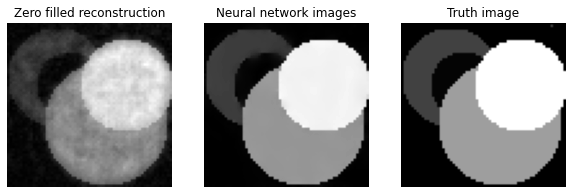

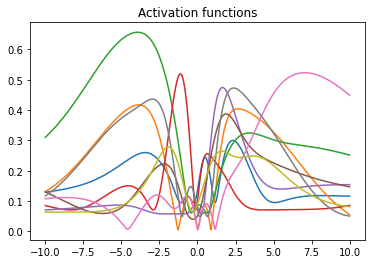

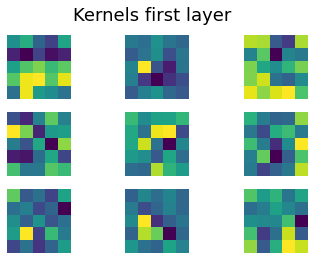

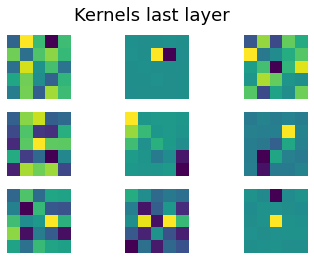

In [14]:
plt.figure(figsize=(10,5))

# Check the images
zero_fill = sense_adjoint(maps2, data2*mask2)
im_sl = zero_fill[0,0].detach().cpu().numpy()
plt.subplot(131)
plt.imshow(np.abs(im_sl), cmap='gray')
plt.title('Zero filled reconstruction')
plt.axis('off')

# Check the images
im_sl = image[0,0].detach().cpu().numpy()
plt.subplot(132)
plt.imshow(np.abs(im_sl), cmap='gray')
plt.title('Neural network images')
plt.axis('off')

# Check the images
im_sl = truth[0,0].detach().cpu().numpy()
plt.subplot(133)
plt.imshow(np.abs(im_sl), cmap='gray')
plt.title('Truth image')
plt.axis('off')
plt.show()

plt.figure()
x = np.linspace(-10,10,2000)
vin = torch.tensor(x).view(-1,1,1,1).type(torch.complex64).cuda()
for alayer in model.varnets[0].activation_layers:
    vout = alayer(vin)
    plt.plot(x,np.squeeze(np.abs(vout.detach().cpu().numpy())))
plt.title('Activation functions')
plt.show()

plt.figure()
for f in range(9):
    plt.subplot(3,3,f+1)
    plt.imshow(np.squeeze(model.varnets[0].encoding_layers[f].conv_r.weight[0,:,:].detach().cpu().numpy()))
    plt.axis('off')
plt.suptitle('Kernels first layer', fontsize=18)
plt.show()

plt.figure()
for f in range(9):
    plt.subplot(3,3,f+1)
    plt.imshow(np.squeeze(model.varnets[-1].encoding_layers[f].conv_r.weight[0,:,:].detach().cpu().numpy()))
    plt.axis('off')
plt.suptitle('Kernels last layer', fontsize=18)
plt.show()